# Assessment 3 - Amazon Food Review

This project aims to conduct sentiment analysis on Amazon Food Reviews using natural language processing methods. The objective is to develop a model capable of effectively determining whether a review expresses positive or negative sentiment based on its textual content.


#Import Libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Deep learning libraries
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization, Bidirectional
from keras.optimizers import Adam

# Regular expressions
import re

# Web scraping
from bs4 import BeautifulSoup

# Text preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

# Operating system functions
import os

# Plotting
import matplotlib.pyplot as plt

# Deep learning libraries (TensorFlow)
from tensorflow.keras.layers import Input, LSTM, Concatenate, TimeDistributed, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Warning handling
import warnings

# Package installation
import wget

# Natural Language Toolkit
import nltk

# Train-test split
from sklearn.model_selection import train_test_split


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ce60ebf54ecbce411d8282ae52ff3b08518fc0d9bb841c5d1fca57ededac4660
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


#Data loading

In [2]:
# load the reviews from a csv file into Pandas
data=pd.read_csv("/content/AmazonReviews.csv",nrows=100000)
#data=pd.read_csv("/content/AmazonReviews.csv")

#Exploratory Data Analysis
Amazon food review NLP EDA examines review lengths, common words, and sentiment. Techniques like topic modeling uncover themes, while aspect-based analysis focuses on specific aspects. EDA informs preprocessing and model selection.

##**Dataset Overview:**

The dataset contains information on the number of entries, giving an overview of its size.

In [3]:
# see how many entries there are
print(data['Text'].shape)

(100000,)


In [4]:
# Limit the data for this exercise to avoid lengthy training times
data = data[:100000]
print(data['Text'].shape)

(100000,)


Displays the first few rows of the dataset.

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [6]:
# Display a random sample of reviews including the score, text, and summary
data[['Score', 'Text', 'Summary']].sample(5)

,Score,Text,Summary
31208,2,that is so unfair. I was a faithful customer now i have to go buy them somewhere else . Why Amazon!!!,why did the price go up for these popchips
98377,5,"its sooo good. yummy, filling, natural. what more could you ask for!",fab healthy snack!
50360,5,"I want to affirm what other reviewers have said about this chocolate. It is a truly ""dark"" chocolate that is not bitter and thus perhaps too sweet for some who are looking for a bar with a higher...","Best ""melt in your mouth"" dark chocolate"
39168,5,"EdenSoy is a brand that I have come to trust. We try to only eat organic and natural healthy foods, and all of the EdenSoy products are pantry staples in our home. They adhere to the highest stand...",Highest quality organic soy milk + shelf stable + delicious!!
55495,4,"As other reviewers have noted already, this seems to be Kellogg's attempt to replicate Honey Nut Cheerios, at least in appearance. Nutritionally the two are also very similar. Crunchy Nut tastes...",Tasty


##Data Cleaning
Removing duplicate entries based on the 'Text' column and droping any rows with missing values in the dataset.

In [7]:
# Remove any duplicate entries in the data
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

##Data preprocessing
Assigning binary labels to the reviews based on their scores. Reviews with scores of 2 or lower are labeled as 0 (indicating negative sentiment), while reviews with scores of 3 or higher are labeled as 1 (indicating positive sentiment).

In [8]:
labels = data['Score']
labels[labels<=2] = 0 # Negative sentiment
labels[labels>=3] = 1 # Positive sentiment

In [9]:
# map words to colloquial terms
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [10]:
# print out the first 10 entries in the data to view it to decide what to do for data cleaning
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [11]:
#!pip install nltk


This process aims to standardize and preprocess the text data for further analysis or modeling.

In [12]:
import nltk
nltk.download('stopwords')  # download the stopwords library for use by NLTK
stop_words = set(stopwords.words('english'))

# a function to clean the text.  Remove whiteapce, html characters, punctuation etc...
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

# store the cleaned text in a list
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# a function to clean the summary text
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

# Call the summary_cleaner function and store the cleaned summaries in a list
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

# store the cleaned text and summaries in a dictionary
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
# drop rows with null values
data.dropna(axis=0,inplace=True)

In [14]:
# add the text _START_ and _END_ to the summaries to easily identify they are the summaries
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [15]:
# print the first 5 reviews and their summaries
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("Score:",data['Score'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_
Score: 1


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_
Score: 0


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_
Score: 1


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_
Score: 0


Review: great taffy great price wide assortment

The resulting histogram provides insight into the distribution of text and summary lengths, helping to decide an appropriate maximum sequence length for further processing.

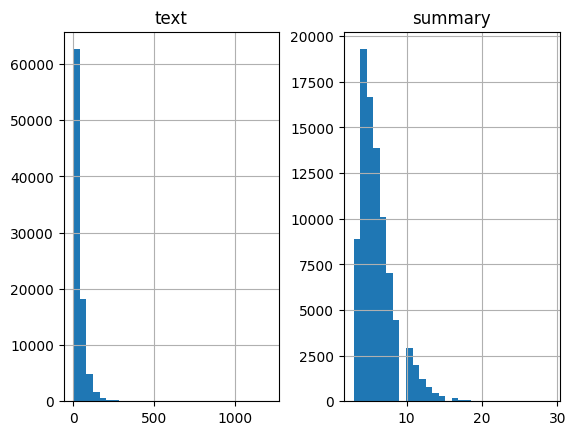

In [16]:
# investigate the distribution of the length of the text in the data
# to help fix the max length of the sequence
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

# Model preparation.

In [17]:
max_len_text = 80 # Setting Maximum Lengths for Text Reviews and Summaries
max_len_summary = 10  # Define maximum lengths for text reviews and summaries

# Splitting the Data into Train and Validation Sets

# Split the cleaned text data and corresponding scores into training and validation sets
# test_size=0.1: 10% of the data will be used for validation, and 90% for training
# random_state=0: Fixing the random seed for reproducibility
# shuffle=True: Shuffling the data before splitting
x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_text'], data['Score'], test_size=0.1, random_state=0, shuffle=True)


 Tokenization and Padding for Text Reviews

In [18]:
# Define the maximum number of words to keep, based on word frequency (size of the vocabulary)
max_words = 50

# Initialize a Tokenizer for text reviews using the training data
x_tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')

# Fit the Tokenizer on the training text data to create a vocabulary
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences into integer sequences using the fitted Tokenizer
x_tr = x_tokenizer.texts_to_sequences(x_tr)  # Training data
x_val = x_tokenizer.texts_to_sequences(x_val)  # Validation data

# Padding sequences with zeros up to the maximum length
x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post')  # Training data
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')  # Validation data

# Calculate the vocabulary size for the tokenized text reviews
x_voc_size = len(x_tokenizer.word_index) + 1


This will output the integer sequence corresponding to the second text review in the training data. Each integer represents a word in the review, and the sequence is padded to the maximum length defined earlier.

In [19]:
print(x_tr[1])

[39 10  6 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


# Neural network modeling

There are three models in this section with different sequential layers. In order to compare and contrast the best model performance.

##Model 1


In [20]:
# Define Sequential model(layers are added sequentially)
model = Sequential()

# Add Embedding layer
model.add(Embedding(x_voc_size, embedding_dim, input_length=80))  #The input length 80, corresponds to the maximum length of the text reviews.

# Add Convolutional layer
model.add(Conv1D(128, 5, activation='relu'))

# Add MaxPooling layer
model.add(MaxPooling1D(5))

# Add Bidirectional LSTM layer with Recurrent Grouped Normalization
model.add(Bidirectional(LSTM(300, recurrent_dropout=0.5, dropout=0.5, recurrent_activation='sigmoid', implementation=2, return_sequences=True)))

# Add second Bidirectional LSTM layer with Recurrent Grouped Normalization
model.add(Bidirectional(LSTM(150, recurrent_dropout=0.5, dropout=0.5, recurrent_activation='sigmoid', implementation=2, return_sequences=True)))

# Add Flatten layer
model.add(Flatten())

# Add Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 10)            515710    
                                                                 
 conv1d (Conv1D)             (None, 76, 128)           6528      
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 128)           0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 15, 600)           1029600   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 15, 300)           901200    
 onal)                                                           
                                                        

##Model 1 accuracy

In [ ]:
# Fit the model
history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=5, batch_size=130, verbose=1)

# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/5
184/184 [==============================] - 233s 1s/step - loss: 0.4158 - accuracy: 0.8484 - val_loss: 0.3855 - val_accuracy: 0.8544
Epoch 2/5
184/184 [==============================] - 206s 1s/step - loss: 0.3821 - accuracy: 0.8516 - val_loss: 0.3862 - val_accuracy: 0.8544
Epoch 3/5
184/184 [==============================] - 208s 1s/step - loss: 0.3756 - accuracy: 0.8512 - val_loss: 0.3802 - val_accuracy: 0.8544
Epoch 4/5
184/184 [==============================] - 213s 1s/step - loss: 0.3739 - accuracy: 0.8516 - val_loss: 0.3827 - val_accuracy: 0.8548
Epoch 5/5
184/184 [==============================] - 214s 1s/step - loss: 0.3723 - accuracy: 0.8519 - val_loss: 0.3795 - val_accuracy: 0.8563
Accuracy: 85.63%


##Model 1 accuracy graph

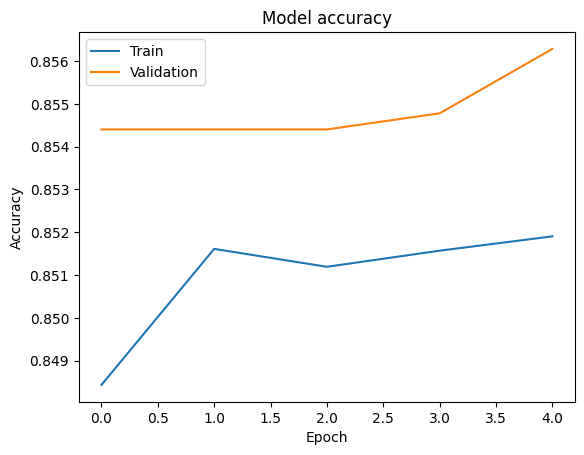

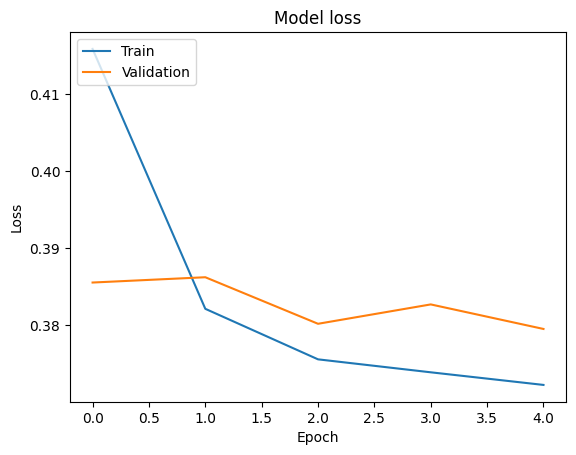

Accuracy: 85.63%


In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


##Model 2

In [20]:
# Define your model
model = Sequential()

# Add Embedding layer
model.add(Embedding(x_voc_size, embedding_dim, input_length=80))

# Add Bidirectional LSTM layer with Recurrent Grouped Normalization
model.add(LSTM(500, recurrent_dropout=0.5, dropout=0.5, recurrent_activation='sigmoid', implementation=2, return_sequences=True))

# Add second Bidirectional LSTM layer with Recurrent Grouped Normalization
model.add(LSTM(100, recurrent_dropout=0.5, dropout=0.5, recurrent_activation='sigmoid', implementation=2, return_sequences=True))

model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 10)            515710    
                                                                 
 lstm (LSTM)                 (None, 80, 500)           1022000   
                                                                 
 lstm_1 (LSTM)               (None, 80, 100)           240400    
                                                                 
 dense (Dense)               (None, 80, 64)            6464      
                                                                 
 dense_1 (Dense)             (None, 80, 1)             65        
                                                                 
Total params: 1784639 (6.81 MB)
Trainable params: 1784639 (6.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##Model 2 accuracy

In [21]:
# Fit the model
history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=8, batch_size=130, verbose=1)

# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/8
612/612 [==============================] - 370s 580ms/step - loss: 0.4243 - accuracy: 0.8515 - val_loss: 0.4235 - val_accuracy: 0.8506
Epoch 2/8
612/612 [==============================] - 343s 560ms/step - loss: 0.3926 - accuracy: 0.8516 - val_loss: 0.3832 - val_accuracy: 0.8506
Epoch 3/8
612/612 [==============================] - 339s 555ms/step - loss: 0.3856 - accuracy: 0.8515 - val_loss: 0.3854 - val_accuracy: 0.8506
Epoch 4/8
612/612 [==============================] - 334s 547ms/step - loss: 0.3816 - accuracy: 0.8516 - val_loss: 0.3793 - val_accuracy: 0.8507
Epoch 5/8
612/612 [==============================] - 341s 558ms/step - loss: 0.3789 - accuracy: 0.8514 - val_loss: 0.4205 - val_accuracy: 0.8506
Epoch 6/8
612/612 [==============================] - 343s 560ms/step - loss: 0.3807 - accuracy: 0.8513 - val_loss: 0.3780 - val_accuracy: 0.8507
Epoch 7/8
612/612 [==============================] - 347s 568ms/step - loss: 0.3769 - accuracy: 0.8515 - val_loss: 0.3744 - val_ac

##Model 2 accuracy graph

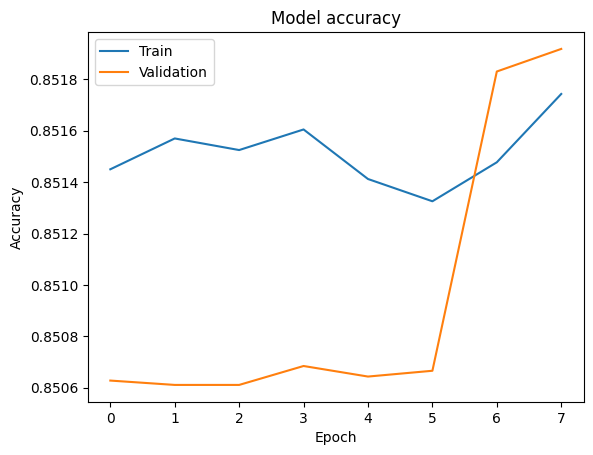

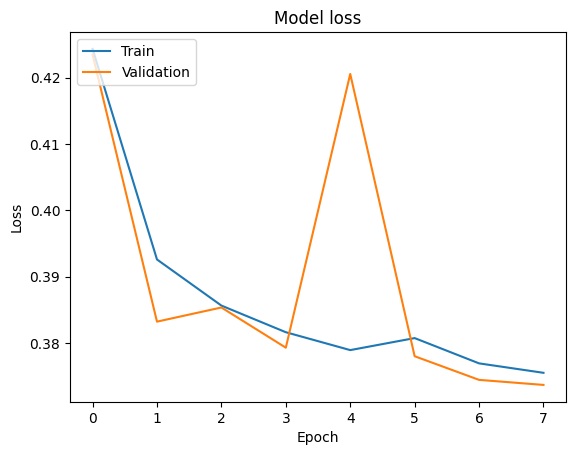

Accuracy: 85.19%


In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


##Model 3

In [32]:
# Define your model
model = Sequential()

# Add Embedding layer
model.add(Embedding(x_voc_size, embedding_dim, input_length=80))

# Add Convolutional layers
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))

# Add LSTM layer
model.add(LSTM(units=64))  # You can specify the number of LSTM units

# Add Dense layer
model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 80, 10)            515710    
                                                                 
 conv1d_2 (Conv1D)           (None, 76, 128)           6528      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 15, 128)           0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                      

##Model 3 aacuracy

In [33]:
# Fit the model
history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=4, batch_size=128, verbose=1)

# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/4
622/622 [==============================] - 8s 7ms/step - loss: 0.3984 - accuracy: 0.8515 - val_loss: 0.3752 - val_accuracy: 0.8506
Epoch 2/4
622/622 [==============================] - 5s 9ms/step - loss: 0.3720 - accuracy: 0.8522 - val_loss: 0.3711 - val_accuracy: 0.8537
Epoch 3/4
622/622 [==============================] - 4s 6ms/step - loss: 0.3691 - accuracy: 0.8526 - val_loss: 0.3707 - val_accuracy: 0.8529
Epoch 4/4
622/622 [==============================] - 4s 6ms/step - loss: 0.3661 - accuracy: 0.8530 - val_loss: 0.3698 - val_accuracy: 0.8532
Accuracy: 85.32%


##Model 3 accuracy graph

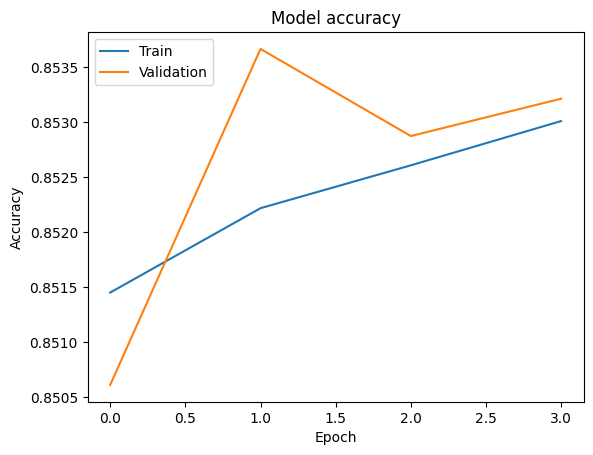

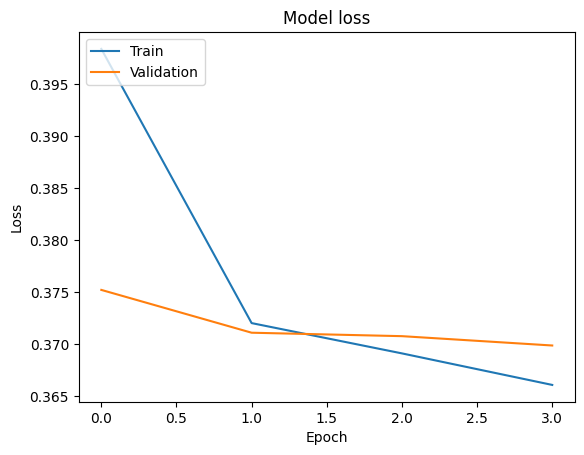

Accuracy: 85.32%


In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
